# VIC: Introduction to Visual Computing - 2023/24
## Assignment 2

**Instructor:** Maria Vakalopoulou </br>
**T.A.:** Nabil Mouadden </br>
**Due Date:** 21/01/2024 </br>

This is VIC Assignment 2. This time you have to **implement a system that outputs object detection bounding boxes of cars in frames extracted from dashcam videos**. You are expected to submit your prediction to a Kaggle challenge at the following link, where you will also find the dataset and further instructions:

https://www.kaggle.com/competitions/vic-kaggle-challenge-20232024/

Let's start first by defining some helper methods for visualization

In [4]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread

data_path = '../data'

H, W = 720, 1280



def read_frame(df_annotation, frame):
    """Read frames and create integer frame_id-s"""
    file_path = df_annotation[df_annotation.index == frame]['frame_id'].values[0]
    return imread(file_path)

def annotations_for_frame(df_annotation, frame):
    assert frame in df_annotation.index
    bbs = df_annotation[df_annotation.index == frame].bounding_boxes.values[0]
    bbs = str(bbs).split(' ')
    if len(bbs)<4:
        return []

    bbs = list(map(lambda x : int(x),bbs))

    return np.array_split(bbs, len(bbs) / 4)

def show_annotation(df_annotation, frame):
    img = read_frame(df_annotation, frame)
    bbs = annotations_for_frame(df_annotation, frame)

    fig, ax = plt.subplots(figsize=(10, 8))

    for x, y, dx, dy in bbs:

        rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.imshow(img)
    ax.set_title('Annotations for frame {}.'.format(frame))

def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """

    mask = np.zeros((H, W))
    for x, y, dx, dy in bounding_boxes:
        mask[y:y+dy, x:x+dx] = 1

    return mask

def run_length_encoding(mask):

    """
    Produces run length encoding for a given binary mask
    """
    
    # find mask non-zeros in flattened representation
    non_zeros = np.nonzero(mask.flatten())[0]
    padded = np.pad(non_zeros, pad_width=1, mode='edge')
    
    # find start and end points of non-zeros runs
    limits = (padded[1:] - padded[:-1]) != 1
    starts = non_zeros[limits[:-1]]
    ends = non_zeros[limits[1:]]
    lengths = ends - starts + 1

    return ' '.join(['%d %d' % (s, l) for s, l in zip(starts, lengths)])

### Training set

You have a set of frames available for training in the `train/` directory, and their bounding boxes in `train.csv`, having format:

```x, y, width, height```



In [6]:
import pandas as pd

df_ground_truth = pd.read_csv(os.path.join(data_path, 'train.csv'))
N = len(df_ground_truth)

df_ground_truth.head()

,frame_id,bounding_boxes
0,train/A_001.jpg,0 225 214 317 0 172 345 254 285 240 155 131 70...
1,train/A_002.jpg,0 254 190 293 0 169 338 271 276 238 160 137 70...
2,train/A_003.jpg,0 306 59 241 0 155 306 318 235 233 191 149 713...
3,train/A_004.jpg,0 143 239 298 164 223 240 172 721 293 94 76 57...
4,train/A_005.jpg,0 217 137 270 55 209 323 208 731 296 99 79 573...


In [4]:
from ipywidgets import interact, widgets
from IPython.display import display

def f_display(frame_id):
    show_annotation(df_ground_truth, frame_id)

interact(f_display, frame_id=widgets.IntSlider(min=0, max=N-1, step=1, value=0))

Your task is to produce bounding boxes for each frame in the `test/` directory.  **N.B.** Because of limitations of in-class Kaggle, your final submission file will be of a slightly different format to `train.csv`.

### Submitting to Kaggle

Submissions to the Kaggle challenge can be made in the form of a .csv file (see `sample_submission.csv`), consisting of two columns with one row per image:
```
Id,Predicted
test/001.jpg,192425 100 193705 100 ...
test/002.jpg,192425 100 193705 100 ...
test/003.jpg,192425 100 193705 100 ...
...
```
`Id` - the image id, which is the path to the image from the project root--must be exact.

`Predicted` - The [run length encoding](https://en.wikipedia.org/wiki/Run-length_encoding) of the binary mask resulting from your concatenated bounding boxes. It is recommended to use the supplied function `run_length_encoding` to automate this. An example is given in the `Assignment2.ipynb` notebook. **N.B.** If you change the size of the images during your pipeline, be sure to resize your final bounding boxes to  (1280x720).

To create a sample submission we will use, as our baseline, a pretrained opencv haar-cascade classifier (for this assignement you will need to replace this by your own detection pipeline)

In [ ]:
!pip install wget
!python -m wget -o cars.xml https://raw.githubusercontent.com/andrewssobral/vehicle_detection_haarcascades/master/cars.xml

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330



Saved under cars (1).xml


['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '80.jpg', '81.jpg', '82.jpg', '83.jpg', '84.jpg', '85.jpg', '86.jpg', '87.jpg', '88.jpg', '89.jpg', '90.jpg', '91.jpg', '92.jpg', '93.jpg', '94.jpg', '95.jpg', '96.jpg', '97.jpg', '98.jpg', '99.jpg', '100.jpg', '101.jp

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'


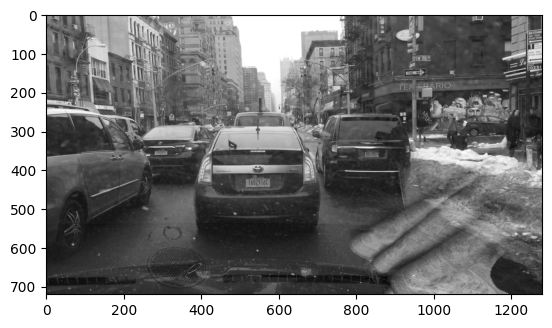

In [16]:
import cv2
# Trained XML classifiers describes some features of some object we want to detect 
car_cascade = cv2.CascadeClassifier('./cars.xml') 
rows = [] 
test_dir = os.path.join(data_path, 'test')
test_files = sorted(os.listdir(test_dir), key=lambda x: int(x.split('.')[0]))
print(test_files)
          
for file_name in test_files:
    test_image = imread(os.path.join(test_dir, file_name)) 
    # convert to gray scale of each frames 
    gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY) 
    plt.imshow(gray, cmap='gray')
      
    # Detects cars of different sizes in the input image 
    cars = car_cascade.detectMultiScale(gray, 1.1, 1) 
    
    # encode the bounding boxes detected for the frame
    rle = run_length_encoding(bounding_boxes_to_mask(cars, H, W))

    #append the predicted bounding boxes to your results' list
    rows.append(['test/' + file_name, rle])

# generate csv submission
df_prediction = pd.DataFrame(columns=['Id', 'Predicted'], data=rows).set_index('Id')
df_prediction.to_csv('sample_submission.csv')

Let's visualize the bounding boxes detected by the classifier to see if it was able to indentify cars in the last frame

In [23]:
for (x,y,w,h) in cars: 
    cv2.rectangle(test_image,(x,y),(x+w,y+h),(0,0,255),2) 

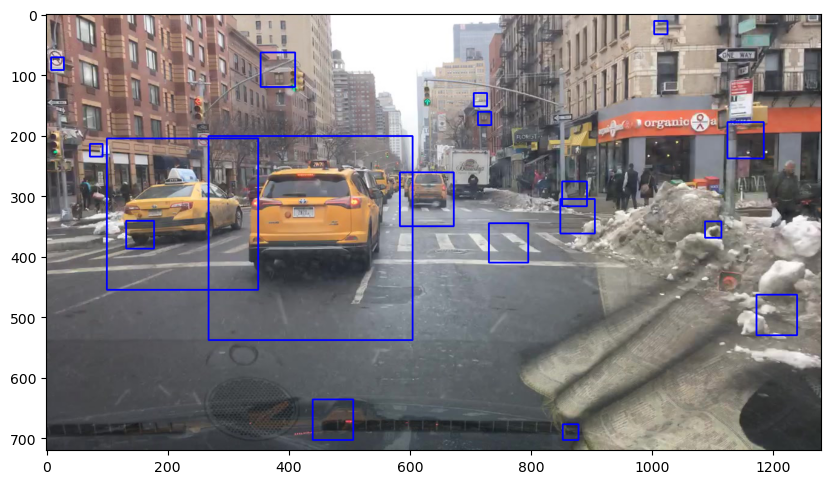

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(test_image)

## Evaluation

Submissions are evaluated with respect to the Sørensen–Dice coefficient,

$$DSC = \frac{2|X \cap Y|}{|X| + |Y|},$$

the intersection of the prediction X and the ground truth solution Y over the sum of their parts. The minimum is 0 (no intersection), and the maximum is 1 (perfect overlap). The mean DSC over all test images is your final score. **N.B.** that although the challenge is posed as an object detection problem, it is evaluated as a segmentation problem i.e. X and Y will be binary masks (see below). This is due to some limitations of Kaggle as used in-class mode.

An unspecified 50% split of the test data contributes to a "public leaderboard", with the remaining data contributing to a "private leaderboard", which is not visible until the end of the competition. This is to prevent overfitting to the test data.